In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [2]:
# loading the preprocessed dataset
file_path = "../data/preprocessed_breast_cancer_data.csv"  # Update path if necessary
data = pd.read_csv(file_path)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2509 entries, 0 to 2508
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   patient_id                      2509 non-null   object 
 1   age_at_diagnosis                2509 non-null   float64
 2   type_of_breast_surgery          2509 non-null   object 
 3   cancer_type                     2509 non-null   object 
 4   cancer_type_detailed            2509 non-null   object 
 5   cellularity                     2509 non-null   object 
 6   chemotherapy                    2509 non-null   int64  
 7   pam50_+_claudin-low_subtype     2509 non-null   object 
 8   cohort                          2509 non-null   float64
 9   er_status_measured_by_ihc       2509 non-null   object 
 10  er_status                       2509 non-null   int64  
 11  neoplasm_histologic_grade       2509 non-null   float64
 12  her2_status_measured_by_snp6    25

In [4]:
# select relevant features
features = ["age_at_diagnosis", "tumor_size", "tumor_stage", "chemotherapy", "hormone_therapy",
           "her2_status", "pr_status", "er_status", "mutation_count", "nottingham_prognostic_index"]

# target varaible
target = "overall_survival_status"

In [5]:
data_ml = data[features + [target]].copy() 

In [6]:
# dropping the target columns from the training data
X = data_ml.drop(columns=[target])

# define y
y = data_ml[target]

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

In [7]:
# scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Machine Learning Models

In [8]:
# Logistic Regression Model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_scaled, y_train)
y_pred_logreg = log_reg.predict(X_test_scaled)
y_pred_logreg_prob = log_reg.predict_proba(X_test_scaled)[:, 1]
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_logreg))

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.57      0.28      0.38       167
           1       0.71      0.89      0.79       335

    accuracy                           0.69       502
   macro avg       0.64      0.59      0.58       502
weighted avg       0.66      0.69      0.65       502



**Observations**
- Performs poorly for Class 0 (Alive) (F1-score=0.38)
- Strong recall for Class 1 (Deceased) (89%), meaning it correctly identifies high-risk patients well.
- Overall accuracy is 69%, but performance is imbalanced.

In [9]:
# Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_rf_prob = rf_model.predict_proba(X_test_scaled)[:, 1]
print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))

Random Forest Results:
              precision    recall  f1-score   support

           0       0.55      0.49      0.52       167
           1       0.76      0.80      0.78       335

    accuracy                           0.70       502
   macro avg       0.65      0.65      0.65       502
weighted avg       0.69      0.70      0.69       502



**Observations**
- Performs better on Class 0 (F1-score = 0.52, up from 0.38).
- Overall accuracy improved slightly to 70%.
- A more balanced classification compared to Logistic Regression.

In [10]:
# Optimized XGBoost Model
xgb_model = XGBClassifier(n_estimators=50, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_pred_xgb_prob = xgb_model.predict_proba(X_test_scaled)[:, 1]
print("XGBoost Results:")
print(classification_report(y_test, y_pred_xgb))

XGBoost Results:
              precision    recall  f1-score   support

           0       0.55      0.56      0.55       167
           1       0.78      0.77      0.78       335

    accuracy                           0.70       502
   macro avg       0.66      0.67      0.66       502
weighted avg       0.70      0.70      0.70       502



**Observations**
- Best balance between Class 0 and Class 1.
- Slightly lower recall for Class 1, but higher precision than other models.
- Best F1-score for Class 0 (0.55), meaning it handles both classes more evenly.
- Best macro-average F1-score (0.66), meaning the overall model is performing better across both classes.

In [11]:
# Compute ROC curve and AUC for each model
fpr_log, tpr_log, _ = roc_curve(y_test, y_pred_logreg_prob)
roc_auc_log = auc(fpr_log, tpr_log)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_prob)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb_prob)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

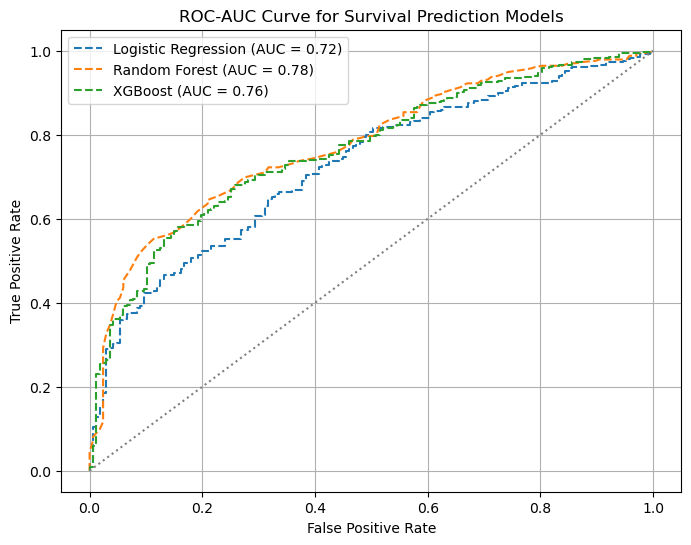

In [12]:
# Plot ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {roc_auc_log:.2f})', linestyle='--')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})', linestyle='--')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})', linestyle='--')

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], color='gray', linestyle='dotted')

# Labels and title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve for Survival Prediction Models")
plt.legend()
plt.grid()

# Show plot
plt.show()

**Observations**
1. **AUC Scores**:
    - **Logistic Regression: 0.72** (performs the worst)
    - **Random Forest: 0.78** (best performance)
    - **XGBoost: 0.76** (slightly worse than Random Forest)

2. **Model Comparison**:
    - **Random Forest** has the **best AUC**, meaning it's better at distinguishing between survivors and non-survivors.
    - **XGBoost performs slightly similar to Random Forest** but is slightly worse.
    - **Logistic Regression is the weakest model** in this comparison.

### Performing Feature Importance

To understand which factors most influence the survival prediction

1. **For Random Forest & XGBoost**:
    - Extract feature importances from the models.

2. **For Logistic Regression**:
    - Use the model's **coefficients** to interpret how each feature impacts survival.

In [13]:
# extract feature importance from Random Forest and XGBoost
feature_names = X.columns

# Random Forest feature importance
rf_importance = rf_model.feature_importances_

# XGBoost Feature Importance
xgb_importance = xgb_model.feature_importances_

# Logistic Regression Coefficients
log_reg_coefficients = np.abs(log_reg.coef_)[0]  # considering absolute values

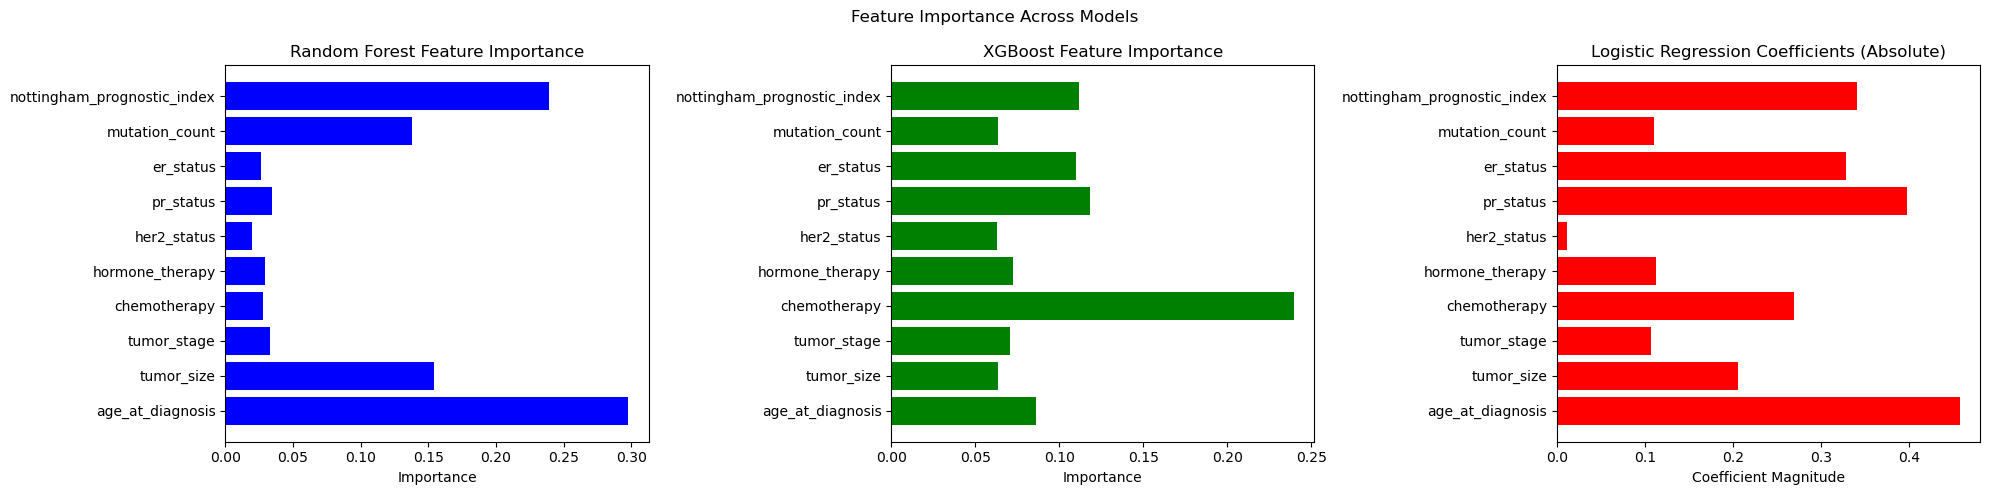

In [14]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle("Feature Importance Across Models")

# Plot Random Forest Feature Importance
axes[0].barh(feature_names, rf_importance, color="blue")
axes[0].set_title("Random Forest Feature Importance")
axes[0].set_xlabel("Importance")

# Plot XGBoost Feature Importance
axes[1].barh(feature_names, xgb_importance, color="green")
axes[1].set_title("XGBoost Feature Importance")
axes[1].set_xlabel("Importance")

# Plot Logistic Regression Coefficients
axes[2].barh(feature_names, log_reg_coefficients, color="red")
axes[2].set_title("Logistic Regression Coefficients (Absolute)")
axes[2].set_xlabel("Coefficient Magnitude")

# Adjust layout and show plot
plt.tight_layout()
plt.show()

### Hyperparameter Tuning

To improve the prediction performance of the models

In [15]:
# hyperparameter tuning for Random Forest
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='roc_auc', n_jobs=-1)
rf_grid.fit(X_train_scaled, y_train)
best_rf = rf_grid.best_estimator_

In [16]:
# Hyperparameter tuning for XGBoost
xgb_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2]
}

xgb_grid = GridSearchCV(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), 
                        xgb_params, cv=5, scoring='roc_auc', n_jobs=-1)
xgb_grid.fit(X_train_scaled, y_train)
best_xgb = xgb_grid.best_estimator_

In [17]:
# Hyperparameter tuning for Logistic Regression
log_reg_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
}

log_reg_grid = GridSearchCV(LogisticRegression(random_state=42), log_reg_params, cv=5, scoring='roc_auc', n_jobs=-1)
log_reg_grid.fit(X_train_scaled, y_train)
best_log_reg = log_reg_grid.best_estimator_

In [18]:
# Display best parameters
best_rf_params = rf_grid.best_params_
best_xgb_params = xgb_grid.best_params_
best_log_reg_params = log_reg_grid.best_params_

print("Best parameters for Random Forest: {}".format(best_rf_params))
print("Best parameters for XGBoost: {}".format(best_xgb_params))
print("Best parameters for Logistic Regression: {}".format(best_log_reg_params))

Best parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Best parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50}
Best parameters for Logistic Regression: {'C': 0.1, 'solver': 'lbfgs'}


### Optimized Models

In [19]:
# Optimized Logistic Regression Model
log_reg = LogisticRegression(C=0.1, 
                             solver='lbfgs', 
                             random_state=42)

log_reg.fit(X_train_scaled, y_train)
y_pred_logreg = log_reg.predict(X_test_scaled)
y_pred_logreg_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

# Print Classification Reports
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_logreg))

print(f"Accuracy: {accuracy_score(y_test, y_pred_logreg):.2f}, F1-Score: {f1_score(y_test, y_pred_logreg):.2f}, ROC-AUC: {roc_auc_log:.2f}")

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.56      0.26      0.36       167
           1       0.71      0.90      0.79       335

    accuracy                           0.69       502
   macro avg       0.64      0.58      0.58       502
weighted avg       0.66      0.69      0.65       502

Accuracy: 0.69, F1-Score: 0.79, ROC-AUC: 0.72


In [20]:
# Optimized Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, 
                                  max_depth=10, 
                                  min_samples_split=10, 
                                  random_state=42)

rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_rf_prob = rf_model.predict_proba(X_test_scaled)[:, 1]

print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))

print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}, F1-Score: {f1_score(y_test, y_pred_rf):.2f}, ROC-AUC: {roc_auc_rf:.2f}")

Random Forest Results:
              precision    recall  f1-score   support

           0       0.61      0.44      0.51       167
           1       0.76      0.86      0.80       335

    accuracy                           0.72       502
   macro avg       0.68      0.65      0.66       502
weighted avg       0.71      0.72      0.71       502

Accuracy: 0.72, F1-Score: 0.80, ROC-AUC: 0.78


In [21]:
# Optimized XGBoost Model
xgb_model = XGBClassifier(n_estimators=50, 
                          learning_rate=0.2, 
                          max_depth=5,
                          random_state=42, 
                          use_label_encoder=False, 
                          eval_metric='logloss')

xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_pred_xgb_prob = xgb_model.predict_proba(X_test_scaled)[:, 1]

print("XGBoost Results:")
print(classification_report(y_test, y_pred_xgb))
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.2f}, F1-Score: {f1_score(y_test, y_pred_xgb):.2f}, ROC-AUC: {roc_auc_xgb:.2f}")

XGBoost Results:
              precision    recall  f1-score   support

           0       0.59      0.52      0.55       167
           1       0.77      0.82      0.80       335

    accuracy                           0.72       502
   macro avg       0.68      0.67      0.68       502
weighted avg       0.71      0.72      0.72       502

Accuracy: 0.72, F1-Score: 0.80, ROC-AUC: 0.76


In [22]:
# Compute ROC curve and AUC for each model
fpr_log, tpr_log, _ = roc_curve(y_test, y_pred_logreg_prob)
roc_auc_log = auc(fpr_log, tpr_log)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_prob)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb_prob)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

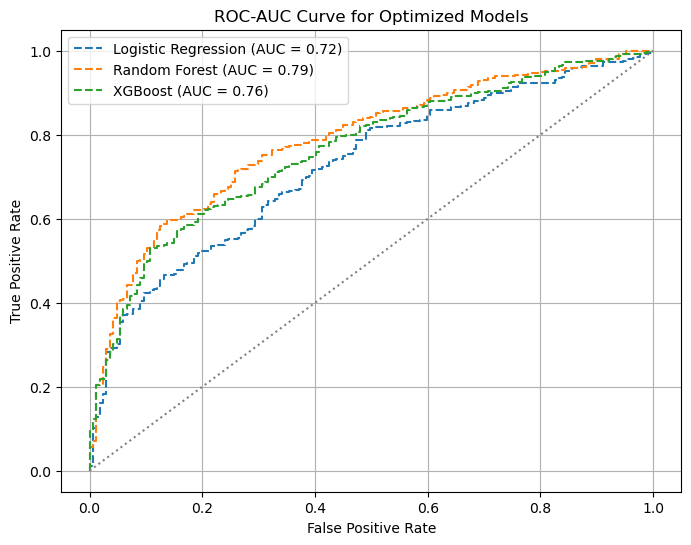

In [23]:
# Plot ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {roc_auc_log:.2f})', linestyle='--')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})', linestyle='--')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})', linestyle='--')

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], color='gray', linestyle='dotted')

# Labels and title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve for Optimized Models")
plt.legend()
plt.grid()

# Show plot
plt.show()

**Key Findings**
- **Random Forest performed the best overall**, with the **highest ROC-AUC (0.79)**.
- **XGBoost was very close**, but had a slightly lower ROC-AUC (0.76).
- **Logistic Regression had the weakest performance**, indicating that **linear relationships alone aren’t sufficient for accurate survival prediction**.


### Interpretation of Results
1. **Models are able to differentiate between high-risk and low-risk patients**, but not with perfect accuracy.
2. **The AUC values (0.72–0.79) suggest the models are better than random guessing**, but there is **room for improvement**.
3. **Feature importance analysis** showed that:
    - **Age at diagnosis, tumor size, and the Nottingham Prognostic Index** are the strongest predictors.
    - **Chemotherapy and hormone therapy also play a role**, especially in XGBoost.
4. **Hyperparameter tuning slightly improved the models**, but not drastically.


### Deep Learning Model

In [24]:
# Define Deep Learning Model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

/Users/sowmyamaddali/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test), verbose=1)

# Predict probabilities
y_pred_nn_prob = model.predict(X_test_scaled).ravel()

# Convert probabilities to class labels
y_pred_nn = (y_pred_nn_prob > 0.5).astype(int)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6592 - loss: 0.6329 - val_accuracy: 0.6733 - val_loss: 0.5887
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.6817 - loss: 0.5861 - val_accuracy: 0.7052 - val_loss: 0.5686
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - accuracy: 0.6886 - loss: 0.5835 - val_accuracy: 0.7092 - val_loss: 0.5548
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.6965 - loss: 0.5755 - val_accuracy: 0.7092 - val_loss: 0.5448
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.7168 - loss: 0.5483 - val_accuracy: 0.7311 - val_loss: 0.5398
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.7055 - loss: 0.5583 - val_accuracy: 0.7371 - val_loss: 0.5366
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.6963 - loss: 0.5678 - val_accuracy: 0.7331 - val_loss: 0.5373
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.7126 - loss: 0.5539 - val_accuracy: 0.73

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step


In [26]:
# Compute ROC curve and AUC
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_nn_prob)
roc_auc_nn = auc(fpr_nn, tpr_nn)

In [27]:
# Print Classification Report
print("Neural Network Results:")
print(classification_report(y_test, y_pred_nn))
print(f"Accuracy: {accuracy_score(y_test, y_pred_nn):.2f}, F1-Score: {f1_score(y_test, y_pred_nn):.2f}, ROC-AUC: {roc_auc_nn:.2f}")

Neural Network Results:
              precision    recall  f1-score   support

           0       0.65      0.49      0.56       167
           1       0.77      0.87      0.82       335

    accuracy                           0.74       502
   macro avg       0.71      0.68      0.69       502
weighted avg       0.73      0.74      0.73       502

Accuracy: 0.74, F1-Score: 0.82, ROC-AUC: 0.76


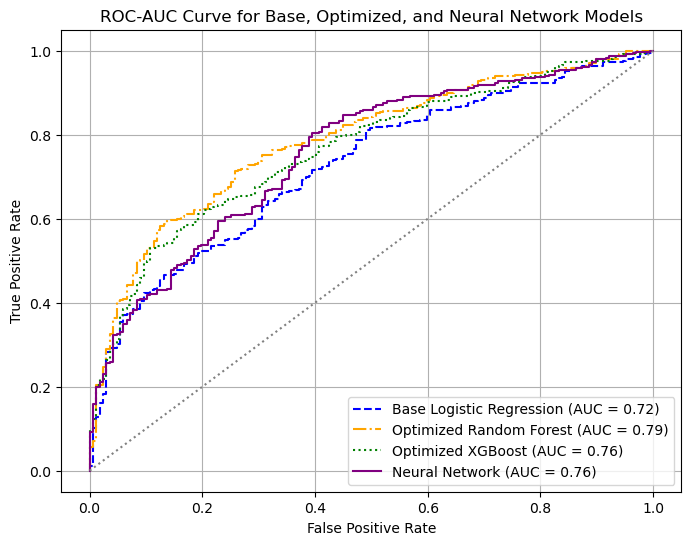

In [31]:
# Plot ROC Curve for Base, Optimized, and Neural Network Models
plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f'Base Logistic Regression (AUC = {roc_auc_log:.2f})', linestyle='--', color='blue')
plt.plot(fpr_rf, tpr_rf, label=f'Optimized Random Forest (AUC = {roc_auc_rf:.2f})', linestyle='-.', color='orange')
plt.plot(fpr_xgb, tpr_xgb, label=f'Optimized XGBoost (AUC = {roc_auc_xgb:.2f})', linestyle=':', color='green')
plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {roc_auc_nn:.2f})', linestyle='solid', color='purple')
plt.plot([0, 1], [0, 1], color='gray', linestyle='dotted')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve for Base, Optimized, and Neural Network Models")
plt.legend()
plt.grid()
plt.show()

**Observations**
1. **Neural Network achieved the highest accuracy (74%)** and F1-score (82%) but had the same **ROC-AUC (0.76) as XGBoost**
2. **Random Forest remains the best for distinguishing high-risk vs. low-risk patients (AUC = 0.79)**.
3. **XGBoost performed slightly worse than Random Forest but had a balanced trade-off**.
4. **Logistic Regression was the weakest model**, meaning linear models alone aren’t enough.

### Final Conclusion: Can patient survival be predicted?

**Yes, machine learning and deep learning models can predict patient survival based on clinical and genetic factors**. However:
   - The models are not perfect and should not be used as a sole decision-making tool.
   - Random Forest and XGBoost are best for clinical applications due to interpretability.
   - Neural Networks provide slight accuracy improvements but are harder to interpret.
   - Future improvements could come from additional features, ensemble learning, or deep learning advancements.